In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [2]:
df = pd.read_csv("AB_Test_Results.csv")
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [3]:
df.shape

(10000, 3)

In [4]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [5]:
np.transpose(df.describe())

,count,mean,std,min,25%,50%,75%,max
USER_ID,10000.0,4981.080200,2890.590115,2.0,2468.75,4962.0,7511.5,10000.00
REVENUE,10000.0,0.099447,2.318529,0.0,0.00,0.0,0.0,196.01


In [6]:
#Vemos cuantos usuarios tienen dos grupos en el A/B testing

grupos = df.groupby("USER_ID")["VARIANT_NAME"].nunique().value_counts()
grupos

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [7]:
#Ahora calculamos la proporción

grupos / grupos.sum()

1    0.756325
2    0.243675
Name: VARIANT_NAME, dtype: float64

In [8]:
single_variant_users = (df.groupby("USER_ID")["VARIANT_NAME"].nunique() == 1)
single_variant_users = single_variant_users[single_variant_users]

In [9]:
df = df[df["USER_ID"].isin(single_variant_users.index)]
df.shape

(6070, 3)

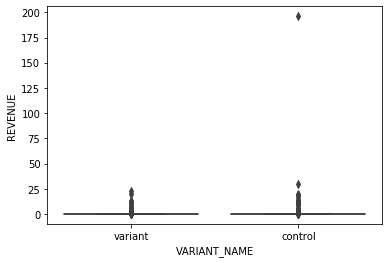

In [10]:
#Ahora vamos a hacer su correspondiente diagrama de caja y bigote

sns.boxplot(x = "VARIANT_NAME", y = "REVENUE", data = df)

In [11]:
#Hay un outlier muy grande, vamos a encontrarlo

df.sort_values(by = "REVENUE", ascending = False).iloc[:10]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99


In [12]:
#Vamos a borrarlo

df = df[df["USER_ID"] != 3342]

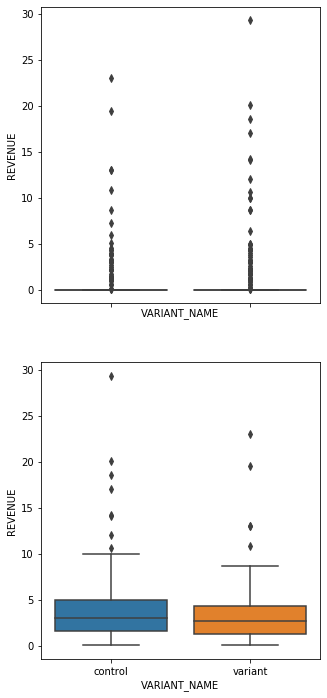

In [13]:
f, axes = plt.subplots(2, sharex = True, figsize = (5,12))

sns.boxplot(ax = axes[0], x = "VARIANT_NAME", y = "REVENUE", data = df)
sns.boxplot(ax = axes[1], x = "VARIANT_NAME", y = "REVENUE", data = df[df["REVENUE"] > 0 ])



In [15]:
#Vamos a buscar a los usuarios que hayan entrado una vez y no hayan tenido compras
#y hayan entrado otra vez para comprar

(df.loc[
    (df["REVENUE"] == 0) & (df["USER_ID"].isin(df.loc[df["REVENUE"] > 0, "USER_ID"])),
    "USER_ID"
]).count()

52

In [44]:
#Vamos a hacer boostrap para encontrar diferencias entre las medias de los dos grupos

def bootstrap(data, n_samples = 1000):
    
    index = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[index]
    
    return samples

In [47]:
control = bootstrap(df.loc[df.VARIANT_NAME == "control", "REVENUE"].values, 10000)
variant = bootstrap(df.loc[df.VARIANT_NAME == "variant", "REVENUE"].values, 10000)

control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

Text(0.5, 1.0, 'Distribrución de las medias de la muestra')

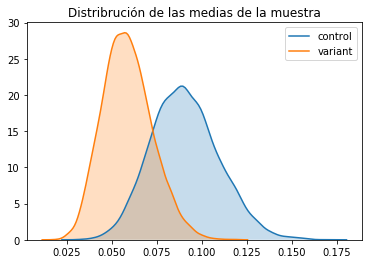

In [54]:
#plot de los dos grupos
sns.kdeplot(np.mean(control, axis = 1),label = "control", shade = True)
sns.kdeplot(np.mean(variant, axis = 1),label = "variant", shade = True)
plt.title("Distribrución de las medias de la muestra")

Text(0.5, 1.0, 'Distribrución de las medias de la muestra de clientes que pagan')

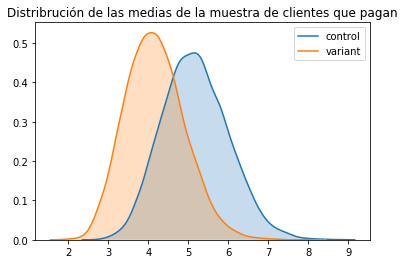

In [55]:
sns.kdeplot(np.mean(control_paid, axis = 1),label = "control", shade = True)
sns.kdeplot(np.mean(variant_paid, axis = 1),label = "variant", shade = True)
plt.title("Distribrución de las medias de la muestra de clientes que pagan")

In [107]:
#Vemos que las medias de los usuarios que han consumido están más proximas que si miramos
#los de todos los usuarios del dataset

In [115]:
control = df.loc[df.VARIANT_NAME == "control", "REVENUE"].values
variant = df.loc[df.VARIANT_NAME == "variant", "REVENUE"].values
control_paid = df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values
variant_paid = df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values

In [111]:
#Vamos a ver si los grupos tienen distribución normal gracias al test de Shapiro-Wilks

s_control, p_control = shapiro(control)
s_variant, p_variant = shapiro(variant)
print("El p-valor del grupo control es {} ".format(p_control))
print("El p-valor del grupo variant es {} ".format(p_variant))

El p-valor del grupo control es 0.0 
El p-valor del grupo variant es 0.0 


Los dos valores son menores a 0.05, por lo que hay evidencia estadística para decir que ninguna de las dos variables sigue una distribución normal

Vamos a utilizar el test de Mann-Whitney para ver si estas dos variables proceden de la misma distribución.

In [112]:
s, p = mannwhitneyu(control, variant)
print("El p-valor es {}".format(p)) 

El p-valor es 0.2859842308619548


Podemos decir que no tenemos evidencia estadística para afirmar que hay diferencias entre el grupo "control" y el "variant" 

In [116]:
#Ahora vamos a hacerlo para los usuarios que han pagado
s, p = mannwhitneyu(control_paid, variant_paid)
print("El p-valor es {}".format(p)) 

El p-valor es 0.4218148352342157


Podemos decir que no tenemos evidencia estadística para afirmar que hay diferencias entre el grupo "control" y el "variant" para los usuarios que han pagado.